# Individual assembly QC and cleanup

In [1]:
from datetime import date
from pycltools.pycltools import jprint

jprint('Adrien Leger / EMBL EBI', bold=True, size=150)
jprint('Starting date : 2020_06_04', bold=True, italic=True, size=125)
jprint('Last modification date : {}_{:02}_{:02}'.format(date.today().year, date.today().month, date.today().day), bold=True, italic=True, size=125)


Bad key "text.kerning_factor" on line 4 in
/nfs/software/birney/adrien/miniconda3/envs/Python3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### imports 

In [2]:
# Standard lib imports
import os
from datetime import date
from collections import *
from glob import glob, iglob
from shutil import rmtree
import itertools
from pprint import pprint as pp
from tqdm import tqdm
import csv
import re

# Generic third party imports
from pycltools.pycltools import *
import pysam
import pyfaidx
import pybedtools as pbt
import pyranges as pr
import mappy as mp

# Ploting lib imports
import matplotlib.pyplot as pl
from matplotlib.colors import rgb2hex
import seaborn as sns
%matplotlib inline

# Data wrangling lib imports
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100
pd.options.display.min_rows = 100

## Copy assembly files

In [116]:
outdir = "individual_assemblies"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

for sample_id in ["69-1_F3", "131-1_F4", "117-2_C4", "4-2_B2", "7-2_F2", "4-1_B2", "134-2_A5", "79-2_G3", "134-1_H4"]:
    fasta = f"/nfs/research1/birney/projects/medaka/inbred_panel/medaka-alignments-release-94/nanopore_assemblies/assembled_fa/{sample_id}.ctg.lay.gz.fa"
    print (f"Copying sample {sample_id}")
    copyFile(fasta, outdir)

for sample_id in ["80-1_H3", "7-1_E2", "11-1_A3"]:
    fasta = f"/nfs/research1/birney/projects/medaka/inbred_panel/medaka-alignments-release-94/nanopore_assemblies/assembled_fa/repeat_runs/{sample_id}.ctg.lay.gz.fa"
    print (f"Copying sample {sample_id}")
    copyFile(fasta, outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/individual_assemblies
Copying sample 69-1_F3
Copying sample 131-1_F4
Copying sample 117-2_C4
Copying sample 4-2_B2
Copying sample 7-2_F2
Copying sample 4-1_B2
Copying sample 134-2_A5
Copying sample 79-2_G3
Copying sample 134-1_H4
Copying sample 80-1_H3
Copying sample 7-1_E2
Copying sample 11-1_A3


### Fix file 11-1_A3.ctg.lay.gz.fa which contains control characters \x00

In [178]:
with open("individual_assemblies/11-1_A3.ctg.lay.gz.fa") as fa_in, open ("individual_assemblies/11-1_A3.ctg.fixed.fa", "w") as fa_out:
    for line in fa_in:
        line = line.strip('\x00').strip()
        fa_out.write(line+"\n")

shutil.move("individual_assemblies/11-1_A3.ctg.fixed.fa", "individual_assemblies/11-1_A3.ctg.lay.gz.fa")

'individual_assemblies/11-1_A3.ctg.lay.gz.fa'

## Rename contig names in assemblies

In [42]:
for fn in glob.glob("./individual_assemblies/*.ctg.lay.gz.fa"):
    n=1
    sample_id = os.path.basename(fn).split(".")[0]
    out_fn = f"./individual_assemblies/{sample_id}_clean.fa"
    stdout_print(f"Parsing sample {sample_id}\n")
    
    with pyfaidx.Fasta(fn) as fa_in, open(out_fn, "w") as fa_out:
        for seq in fa_in:
            fa_out.write(f">MIKK_{sample_id}_{n}\n{str(seq)}\n")
            n+=1
            
    with pyfaidx.Fasta(out_fn) as fa_out:
        print(f"\tNumber of bases {len(fa_out)}")
        print(f"\tNumber of contigs {len(fa_out.keys())}")

Parsing sample 11-1_A3
	Number of bases 728550441
	Number of contigs 3368
Parsing sample 7-1_E2
	Number of bases 732454342
	Number of contigs 2512
Parsing sample 80-1_H3
	Number of bases 720959413
	Number of contigs 4374
Parsing sample 134-1_H4
	Number of bases 731863475
	Number of contigs 3142
Parsing sample 79-2_G3
	Number of bases 730361544
	Number of contigs 3053
Parsing sample 134-2_A5
	Number of bases 729140748
	Number of contigs 3977
Parsing sample 4-1_B2
	Number of bases 730824717
	Number of contigs 2886
Parsing sample 7-2_F2
	Number of bases 732453614
	Number of contigs 2892
Parsing sample 4-2_B2
	Number of bases 737644925
	Number of contigs 2762
Parsing sample 117-2_C4
	Number of bases 732119004
	Number of contigs 2810
Parsing sample 131-1_F4
	Number of bases 741972642
	Number of contigs 3651
Parsing sample 69-1_F3
	Number of bases 727390278
	Number of contigs 3077


### Quick assembly QC

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/individual_assemblies/summary


,Cumulative length,Contig number,min,D1,Q1,median,Q3,D9,max,N50
11-1,728550441,3368,2072,7331,16555,60444,246833,600212,4525370,624727
117-2,732119004,2810,2410,7404,15937,57801,262502,772099,5059334,903899
131-1,741972642,3651,1943,6940,13239,40802,202608,582185,5589066,737055
134-1,731863475,3142,1794,7735,15655,61007,256736,667594,4138056,746317
134-2,729140748,3977,1305,8050,18108,67650,226445,500820,3835876,475444
4-1,730824717,2886,2666,7458,15089,65743,287640,729409,5635124,802725
4-2,737644925,2762,2182,6838,13742,49624,263019,758172,6376848,971613
69-1,727390278,3077,3351,8033,18038,69267,272534,676657,6080511,708738
7-1,732454342,2512,1367,7795,17312,71039,312874,859525,5851261,942347
7-2,732453614,2892,2591,7924,17331,59339,278416,756735,4099264,845096


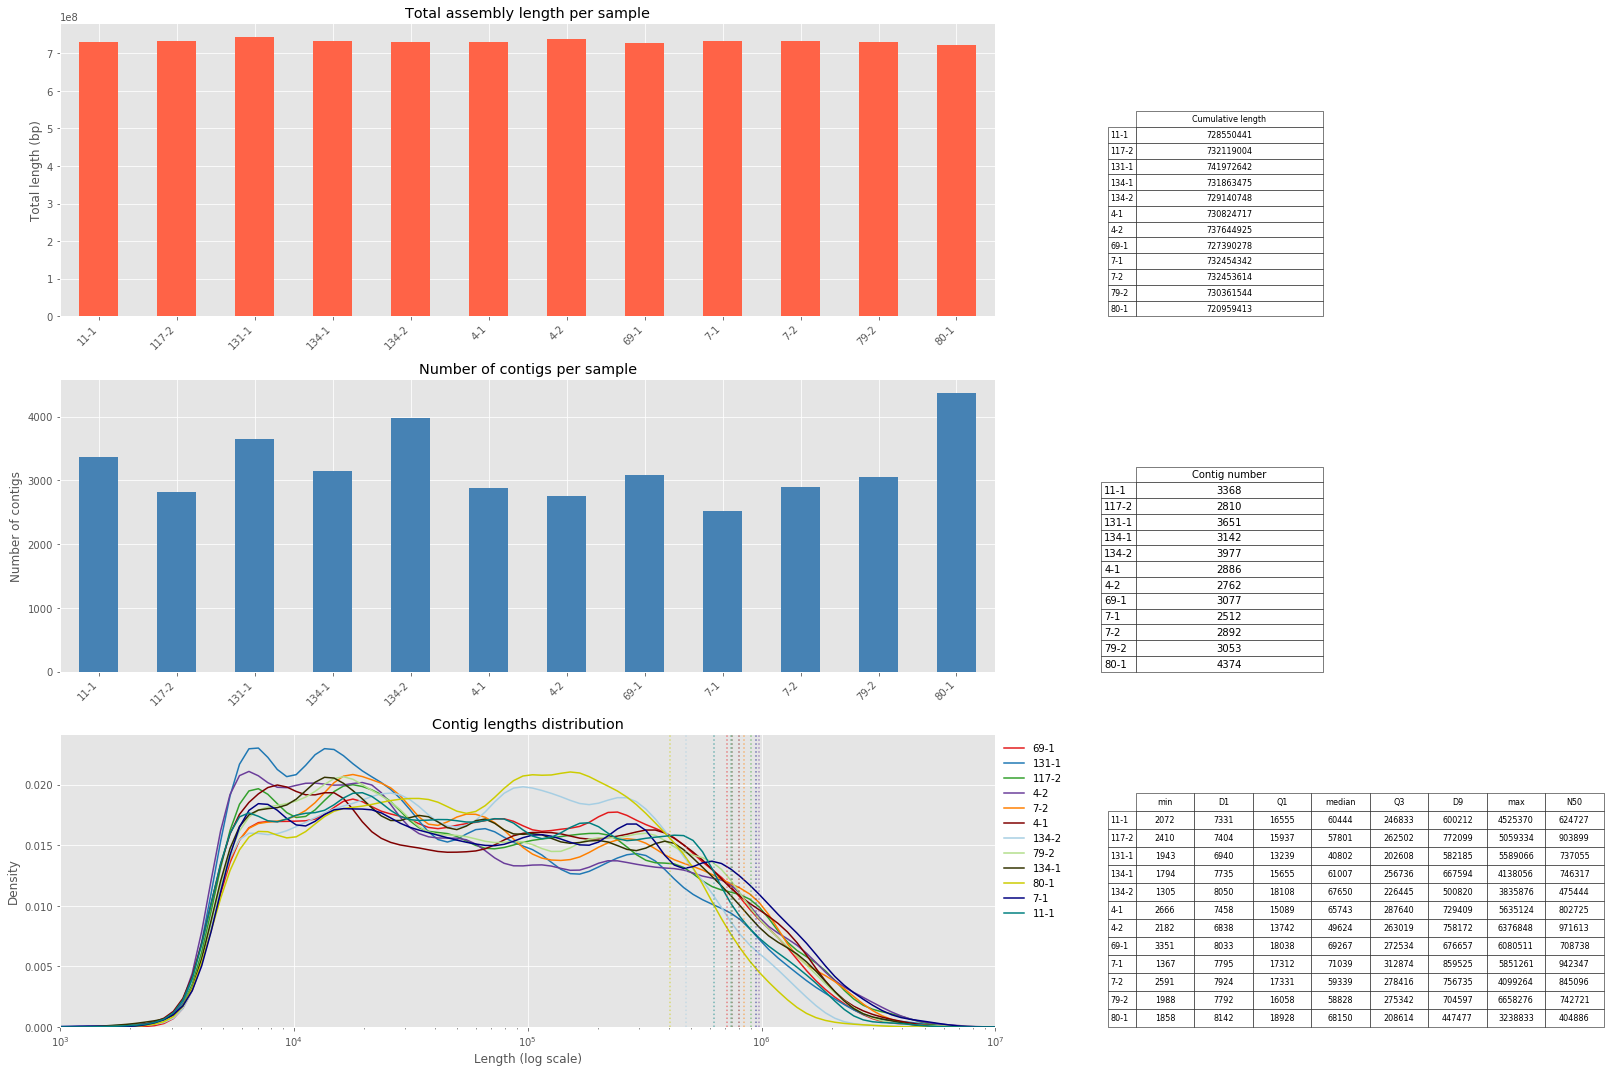

In [114]:
outdir = "./individual_assemblies/summary"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

from pandas.plotting import table
from scipy.ndimage import gaussian_filter1d

def compute_N50 (data):
    data.sort()
    half_sum = sum(data)/2
    cum_sum = 0
    for v in data:
        cum_sum += v
        if cum_sum >= half_sum:
            return int(v)

n_base_d = Counter ()
n_contig_d = Counter ()
len_contig_d = defaultdict(list)

for fn in glob.glob("./individual_assemblies/*_clean.fa"):
    sample_id = os.path.basename(fn).split("_")[0]
    
    with pyfaidx.Fasta(fn) as fa_in:
        for seq in fa_in:
            n_base_d[sample_id] += len(seq)
            n_contig_d[sample_id] += 1
            len_contig_d[sample_id].append(len(seq))

n_base_df = pd.DataFrame.from_dict(n_base_d, orient="index", columns=["Cumulative length"])
n_contig_df = pd.DataFrame.from_dict(n_contig_d, orient="index", columns=["Contig number"])

# Process data for summary dataframe
percentile_val = (0, 10, 25, 50, 75, 90, 100)
percentile_lab = ("min", "D1", "Q1", "median", "Q3", "D9", "max")
summary_len_d = defaultdict(OrderedDict)
for sample_id, sample_len_list in len_contig_d.items():
    percentile = np.int32(np.percentile(sample_len_list, percentile_val))
    for l, p in zip(percentile_lab, percentile):
        summary_len_d[sample_id][l]=p
    summary_len_d[sample_id]["N50"] = compute_N50(sample_len_list)
summary_len_df = pd.DataFrame.from_dict(summary_len_d, orient="index")

# Sort index of DF
n_base_df = n_base_df.sort_index()
n_contig_df = n_contig_df.sort_index()
summary_len_df = summary_len_df.sort_index()

# Process data for plot
bins = list(np.logspace(3,7,100))
count_d=OrderedDict()
count_d["length bin"] = bins
for sample_id, sample_len_list in len_contig_d.items():
    count_d[sample_id] = np.histogram((sample_len_list), bins=bins+[1e10])[0]
count_df= pd.DataFrame.from_dict(count_d)
count_df = count_df.set_index("length bin")
count_df = count_df/count_df.sum(axis=0)
for col in count_df.columns:
    count_df[col] = gaussian_filter1d (count_df[col], sigma=2)

with pl.style.context('ggplot'):
    
    fig, (ax1, ax2, ax3) = pl.subplots(3, 1, figsize=(15,15))
    
    n_base_df.plot.bar(ax=ax1, color="tomato", legend=False)
    table(ax1, n_base_df, colWidths=[0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,0.7))
    ax1.set_title('Total assembly length per sample')
    ax1.set_ylabel("Total length (bp)")
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    n_contig_df.plot.bar(ax=ax2, color="steelblue", legend=False)
    table(ax2, n_contig_df, colWidths=[0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,0.7))
    ax2.set_title('Number of contigs per sample')
    ax2.set_ylabel("Number of contigs")
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    
    labels = ['69-1', '131-1', '117-2', '4-2', '7-2', '4-1', '134-2', '79-2', '134-1','80-1', '7-1', '11-1']
    color_list = ["#e31a1cff","#1f78b4ff","#33a02cff","#6a3d9aff","#ff7f00ff","#800000ff","#a6cee3ff","#b2df8aff","#333300ff","#cccc00ff","#000080ff","#008080ff"]
    color_dict = {lab:col for lab, col in zip(labels, color_list)}
    
    for label, data in count_df.iteritems():
        ax3.plot(data.index, data.values, color=color_dict[label], label=label)
    for label, n50 in summary_len_df["N50"].items():
        ax3.axvline(n50, color=color_dict[label], ls=":", alpha=0.5)
    ax3.legend(bbox_to_anchor=(1, 1), loc=2, facecolor='white', frameon=False)
    
    table(ax3, summary_len_df, colWidths=[0.05]*8, colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.5,0.8))
    ax3.set_xscale("log")
    ax3.set_xlabel("Length (log scale)")
    ax3.set_ylabel("Density")
    ax3.set_title("Contig lengths distribution")
    ax3.set_xlim(1e3,1e7)
    ax3.set_ylim(0,None)
        
    fig.tight_layout()
    
    out_fn = os.path.join(f"{outdir}/assembly_stats.svg")
    fig.savefig(out_fn)


all_df = pd.concat([n_base_df, n_contig_df, summary_len_df], axis=1)
all_df.to_csv(f"{outdir}/assembly_stats.tsv", sep="\t")
display(all_df)

### QUAST assembly QC

In [34]:
fn_list = glob.glob("./individual_assemblies/*clean.fa")
lab_list = [os.path.basename(fn).split("_")[0] for fn in fn_list]
reference = "./references/Oryzias_latipes_HDRR_clean.fa"
outdir = "./individual_assemblies/quast/"
annotation = "./references/Oryzias_latipes_HDRR_sorted.gff3"
threads = 40
mem = 60000

fn_str = " ".join(fn_list)
lab_str = ",".join(lab_list)

cmd = f"quast-lg --silent -o {outdir} -r {reference} -g gene:{annotation} --threads {threads} --memory-efficient --plots-format svg -l {lab_str} {fn_str}"
bsub(cmd, conda="Quast", threads=threads, mem=mem, dry=False, job_name="Quast")

bsub -J Quast -M 60000 -R 'rusage[mem=60000]' -n 40  "quast-lg --silent -o ./individual_assemblies/quast/ -r ./references2/Oryzias_latipes_HDRR_clean.fa -g gene:./references2/Oryzias_latipes_HDRR_sorted.gff3 --threads 40 --memory-efficient -l 69-1,131-1,117-2,4-2,7-2,4-1,134-2,79-2,134-1,80-1,7-1,11-1 ./individual_assemblies/69-1_F3_clean.fa ./individual_assemblies/131-1_F4_clean.fa ./individual_assemblies/117-2_C4_clean.fa ./individual_assemblies/4-2_B2_clean.fa ./individual_assemblies/7-2_F2_clean.fa ./individual_assemblies/4-1_B2_clean.fa ./individual_assemblies/134-2_A5_clean.fa ./individual_assemblies/79-2_G3_clean.fa ./individual_assemblies/134-1_H4_clean.fa ./individual_assemblies/80-1_H3_clean.fa ./individual_assemblies/7-1_E2_clean.fa ./individual_assemblies/11-1_A3_clean.fa"
Job <6840936> is submitted to default queue <research-rh74>.


'6840936'

In [3]:
pd.read_csv("./individual_assemblies/quast/transposed_report.tsv", sep="\t", index_col=0).sort_index()

,# contigs (>= 0 bp),# contigs (>= 1000 bp),# contigs (>= 5000 bp),# contigs (>= 10000 bp),# contigs (>= 25000 bp),# contigs (>= 50000 bp),Total length (>= 0 bp),Total length (>= 1000 bp),Total length (>= 5000 bp),Total length (>= 10000 bp),Total length (>= 25000 bp),Total length (>= 50000 bp),# contigs,Largest contig,Total length,Reference length,GC (%),Reference GC (%),N50,NG50,N90,NG90,L50,LG50,L90,LG90,# misassemblies,# misassembled contigs,Misassembled contigs length,# local misassemblies,# scaffold gap ext. mis.,# scaffold gap loc. mis.,# possible TEs,# unaligned mis. contigs,# unaligned contigs,Unaligned length,Genome fraction (%),Duplication ratio,# N's per 100 kbp,# mismatches per 100 kbp,# indels per 100 kbp,# genomic features,Largest alignment,Total aligned length,NA50,NGA50,NA90,NGA90,LA50,LGA50,LA90,LGA90
Assembly,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11-1,3368,3368,3300,2858,2235,1801,728550441,728550441,728249213,725125738,714885638,699240390,3365,4525370,728542858,734057086,40.56,40.84,624727,620071,124149,114600,316,321,1260,1301,3218,1037,537255616,59404,0,0,2886,700,557 + 2783 part,182815162,75.300,0.988,0.0,1726.82,1409.92,4863 + 17004 part,1541261,545652612,180262,177143,-,-,953,968,-,-
117-2,2810,2810,2764,2352,1835,1478,732119004,732119004,731911910,728953094,720350958,707651040,2808,5059334,732113747,734057086,40.73,40.84,903899,903202,158734,152043,227,228,957,969,4854,1136,610866120,46690,0,0,3762,590,322 + 2407 part,111106346,84.922,0.997,0.0,1132.46,995.35,8524 + 13870 part,2195961,620809739,270130,269002,-,-,712,716,-,-
131-1,3651,3651,3583,2975,2176,1723,741972642,741972642,741670402,737367207,724360480,708516718,3647,5589066,741963499,734057086,40.72,40.84,737055,760902,114467,127005,273,267,1197,1139,4329,1098,550260247,52375,0,0,4204,970,548 + 3009 part,178050369,76.930,0.999,0.0,1411.75,1008.41,7227 + 14877 part,2231101,563763739,180572,183503,-,-,951,929,-,-
134-1,3142,3142,3093,2669,2063,1658,731863475,731863475,731653955,728608772,718779490,704116687,3134,4138056,731842804,734057086,40.71,40.84,747064,743484,131389,128389,274,276,1123,1138,4250,1166,584385643,49134,0,0,3534,610,376 + 2675 part,124762382,83.221,0.994,0.0,1271.78,1084.02,7620 + 14634 part,2042573,606908341,245116,244876,-,-,779,783,-,-
134-2,3977,3977,3917,3441,2732,2205,729140748,729140748,728872266,725484046,713767746,695242695,3973,3835876,729131624,734057086,40.75,40.84,475444,470988,98008,93985,426,432,1668,1714,4825,1490,520433751,45197,0,0,3730,687,359 + 3441 part,107583242,84.886,0.998,0.0,1069.98,936.28,8783 + 13530 part,1698873,621355180,209441,206967,-,-,923,935,-,-
4-1,2886,2886,2824,2400,1878,1571,730824717,730824717,730549578,727452559,718975837,707906448,2883,5635124,730816425,734057086,40.66,40.84,802725,797058,151668,147423,259,261,1034,1053,4021,1092,592002443,50934,0,0,3660,587,383 + 2439 part,131473023,82.319,0.992,0.0,1373.31,1209.13,7003 + 15232 part,2340443,599170757,259311,255515,-,-,746,753,-,-
4-2,2762,2762,2692,2260,1712,1377,737644925,737644925,737325828,734248805,725265239,713393073,2759,6376848,737637241,734057086,40.71,40.84,971613,981023,173477,182060,205,203,864,846,4404,1014,627209679,48857,0,0,3800,630,439 + 2273 part,124494633,84.044,0.994,0.0,1240.50,1125.20,7689 + 14668 part,2781976,612988975,279257,281643,-,-,678,672,-,-
69-1,3077,3077,3034,2652,2112,1724,727390278,727390278,727194307,724432183,715606484,701784840,3077,6080511,727390278,734057086,40.59,40.84,708738,701776,135723,125013,292,297,1170,1216,3508,1153,572944670,56036,0,0,3302,600,395 + 2654 part,154149946,78.996,0.989,0.0,1598.75,1360.35,5675 + 16400 part,1823612,573096833,220342,217551,-,-,830,845,-,-
7-1,2512,2512,2476,2135,1700,1396,732454342,732454342,732301371,729824896,722552085,711527268,2509,5851261,732447291,734057086,40.69,40.84,942347,942347,172910,170443,217,217,878,887,4200,1024,620929268,49627,0,0,3564,544,278 + 2186 part,124267298,83.448,0.993,0.0,1311.65,1164.84,7332 + 14948 part,2243072,60801458

In [7]:
from IPython.display import IFrame
IFrame("./individual_assemblies/quast/report.pdf", width=1600, height=800)